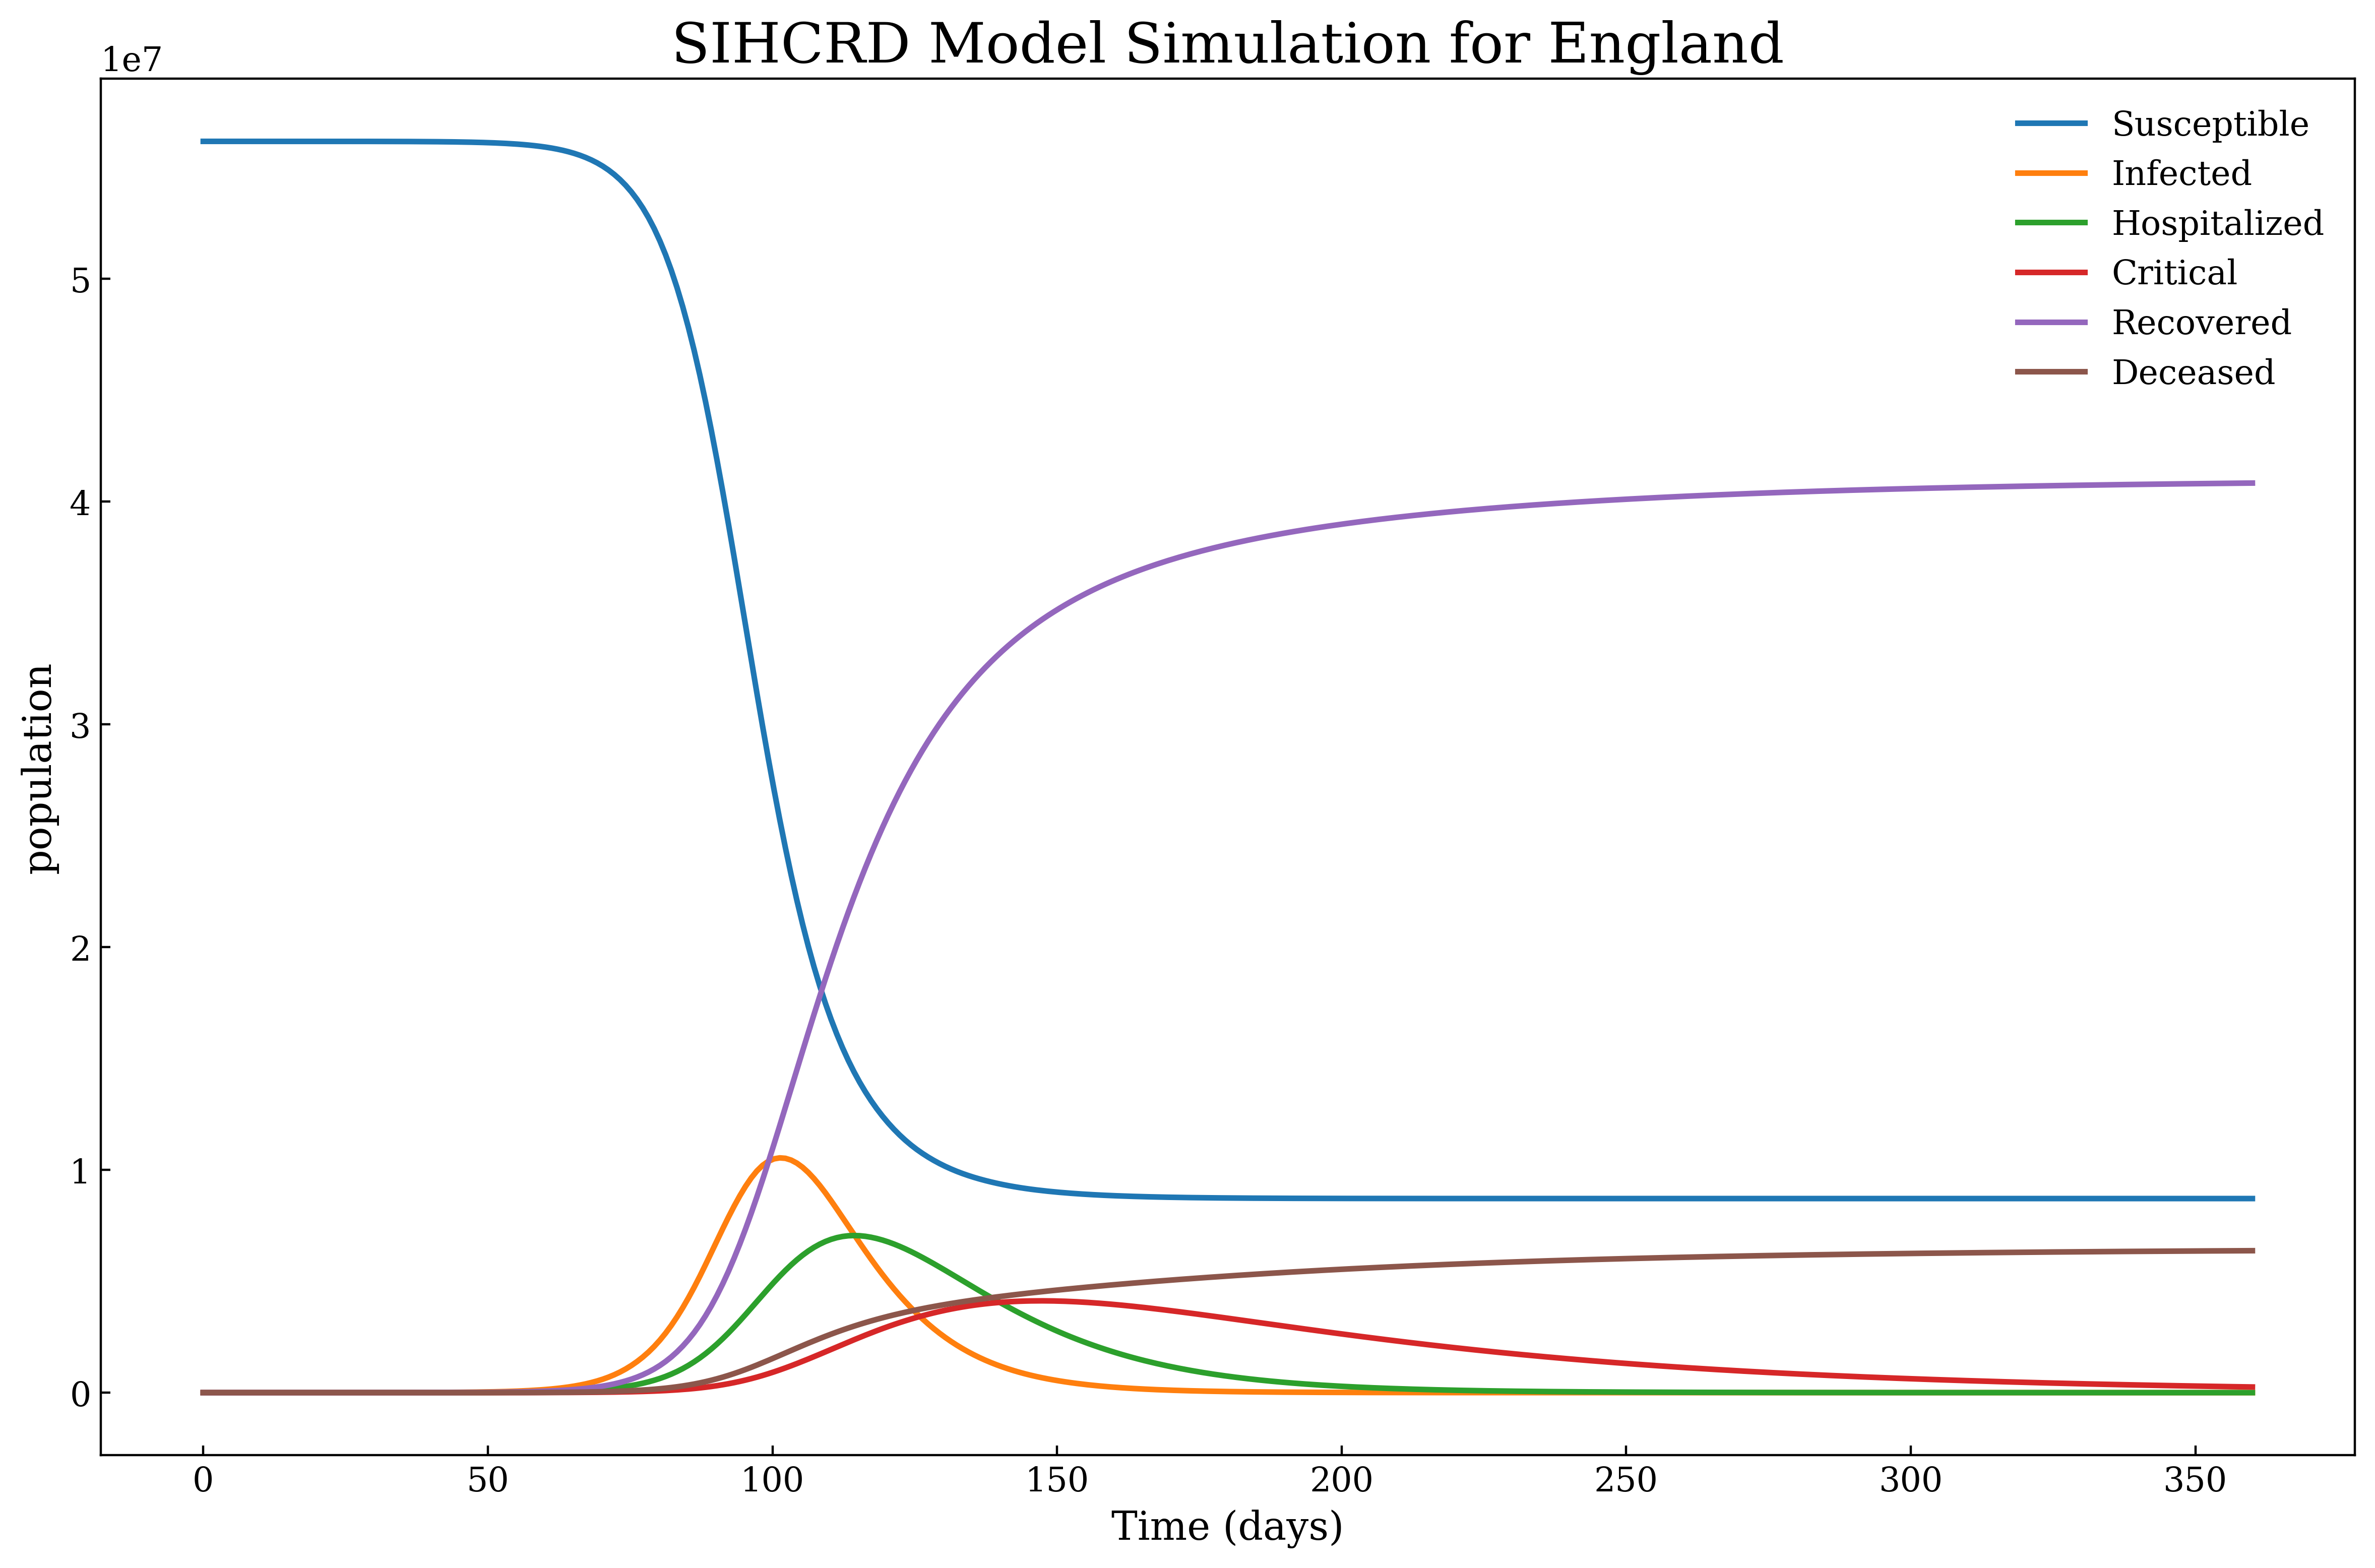

<ipython-input-1-2a60bd7f6e66>:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[columns_to_scale] = transformer.transform(train_data[columns_to_scale])


Epoch 0, Loss: 70.984894
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
Epoch 100, Loss: 0.111856
Epoch 200, Loss: 0.093269
Epoch 300, Loss: 0.076666
Epoch 400, Loss: 0.060663
Epoch 500, Loss: 0.020903
Epoch 600, Loss: 0.011852
Epoch 700, Loss: 0.010422
Epoch 800, Loss: 0.009598
Epoch 900, Loss: 0.008954
Epoch 1000, Loss: 0.008405
Epoch 1100, Loss: 0.007917
Epoch 1200, Loss: 0.007473
Epoch 1300, Loss: 0.007068
Epoch 1400, Loss: 0.006696
Epoch 1500, Loss: 0.006354
Epoch 1600, Loss: 0.006038
Epoch 1700, Loss: 0.005747
Epoch 1800, Loss: 0.005478
Epoch 1900, Loss: 0.005231
Epoch 2000, Loss: 0.005002
Epoch 2100, Loss: 0.004791
Epoch 2200, Loss: 0.004596
Epoch 2300, Loss: 0.004415
Epoch 2400, Loss: 0.004249
Epoch 2500, Loss: 0.004094
Epoch 2600, Loss: 0.003951
Epoch 2700, Loss: 0.003818
Epoch 2800, Loss: 0.003694
Epoch 2900, Loss: 0.003579
Epoch 3000, Loss: 0.003472
Epoch 3100, Loss: 0.003371
Epoch 3200,

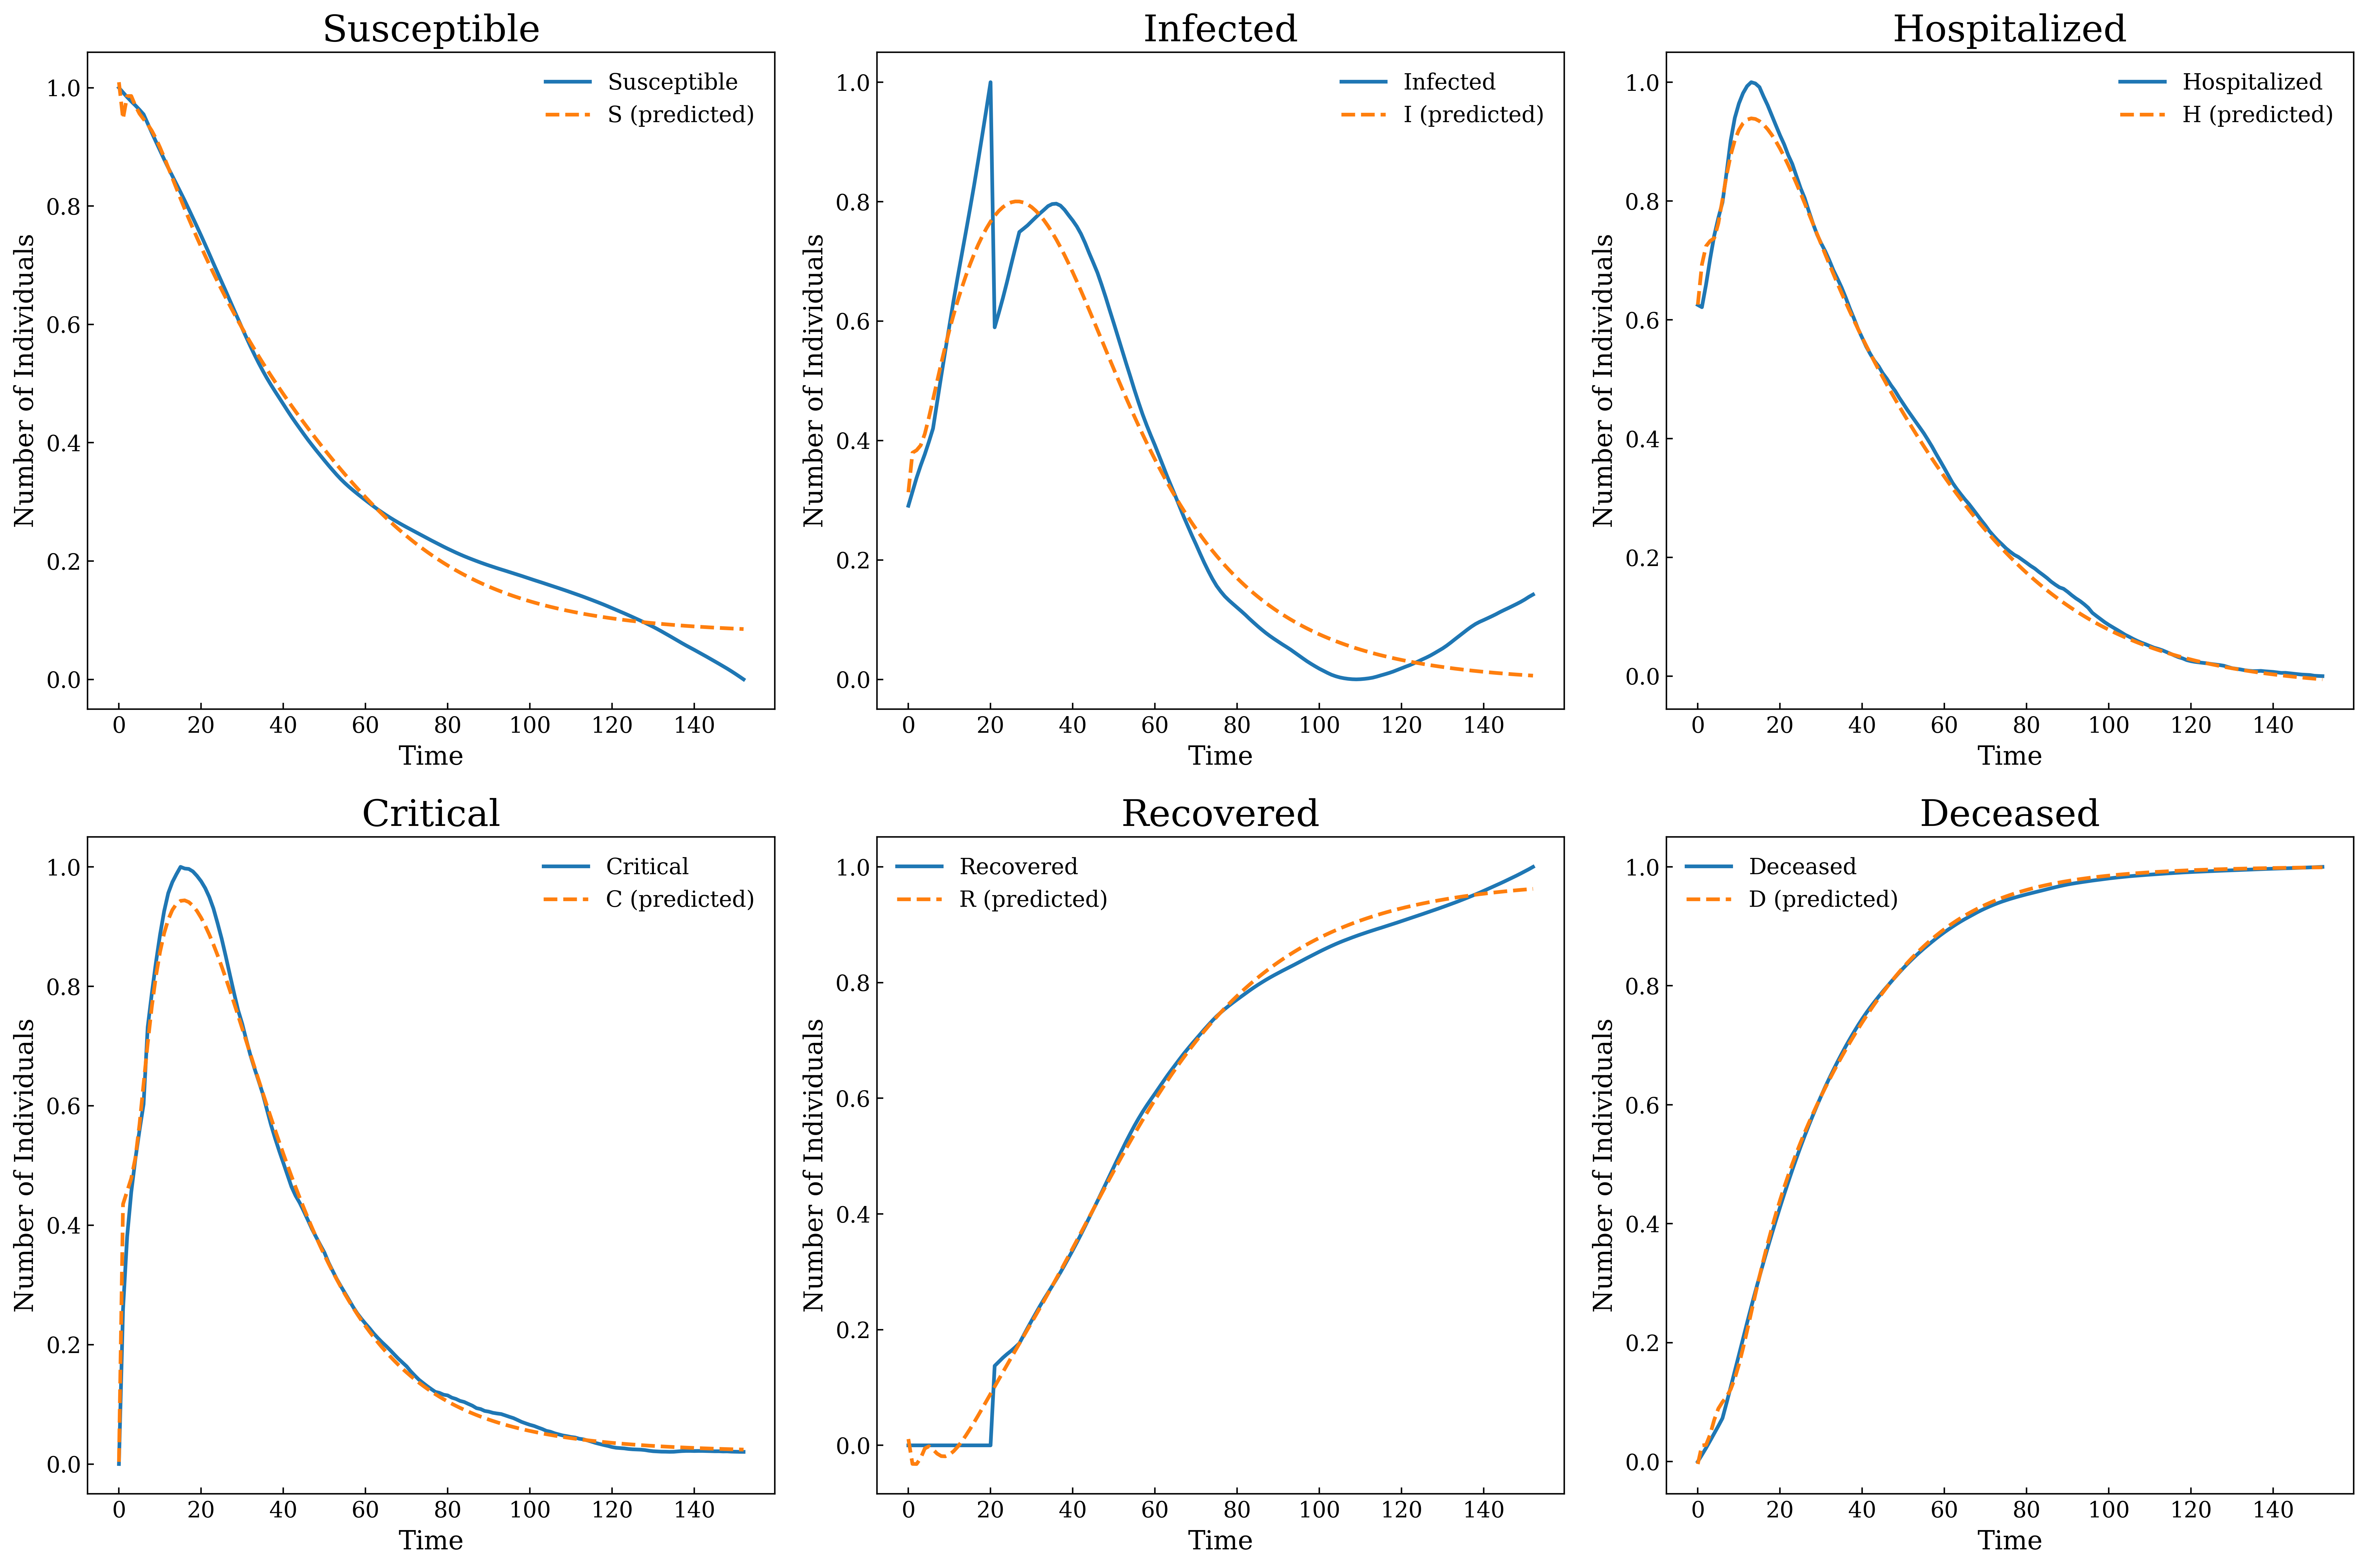

Plot saved to: ../../reports/figures/SIHCRD_Model_loss.pdf


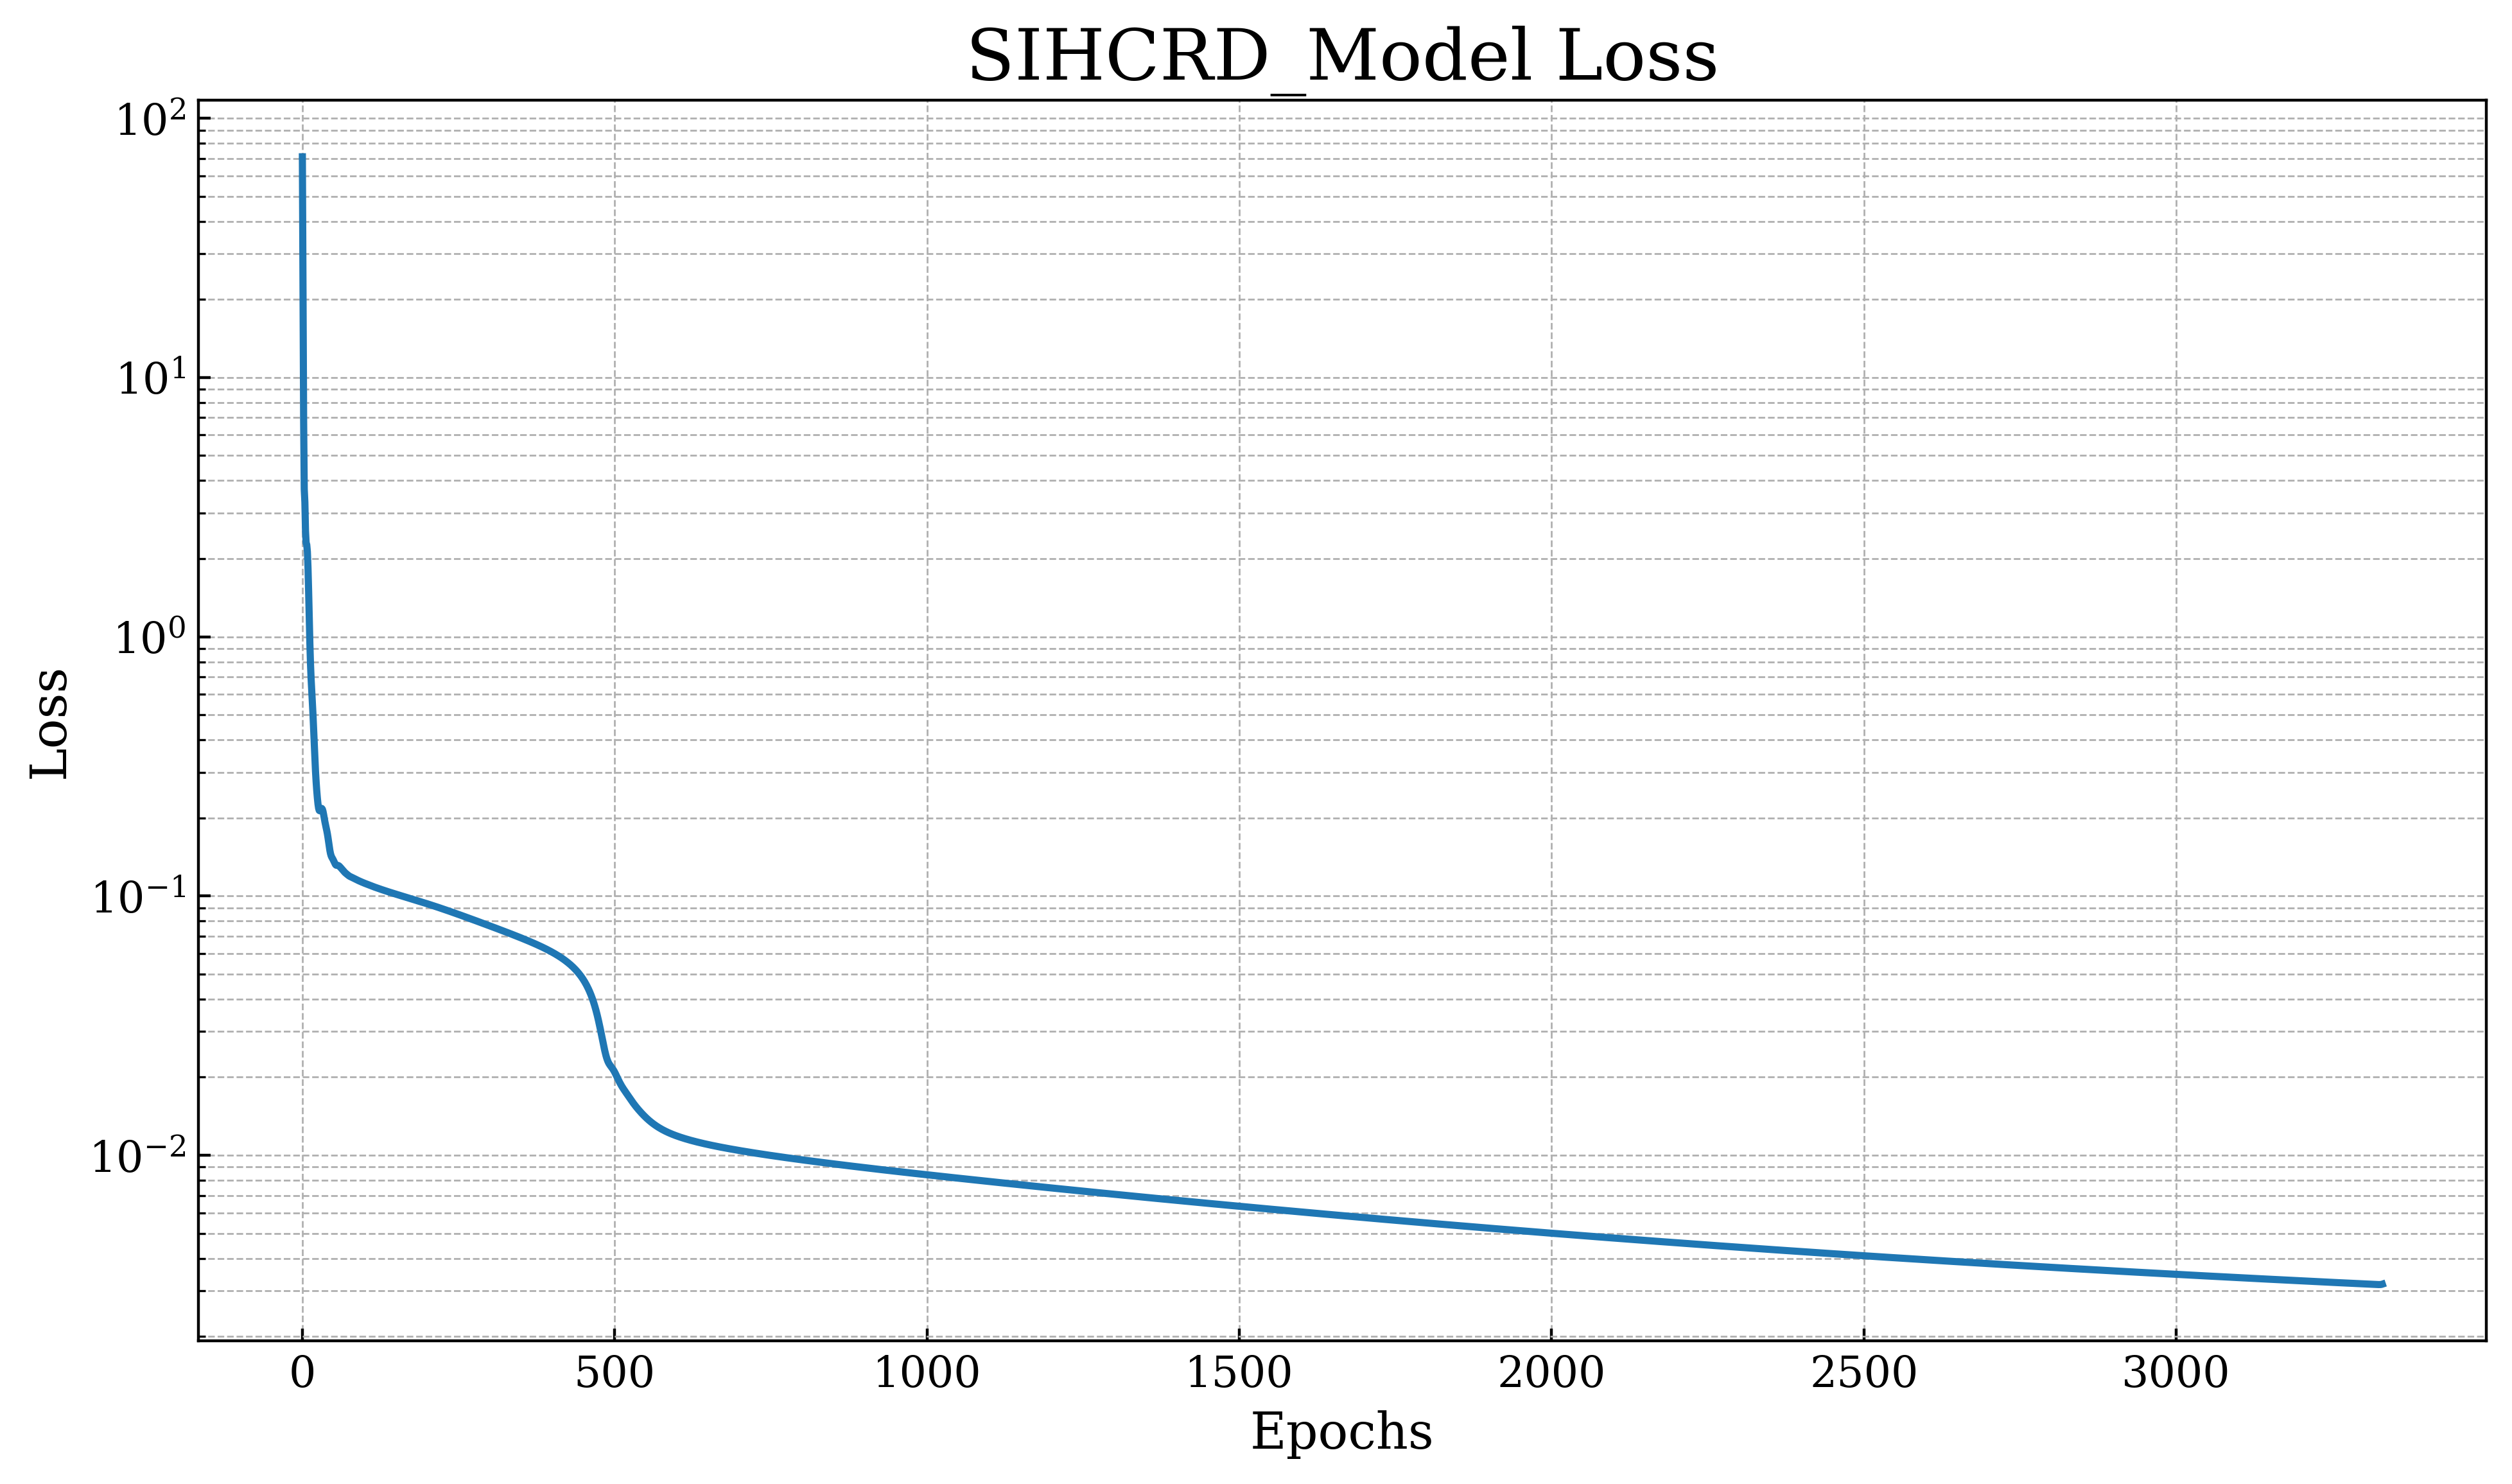

Predicted beta: 0.5768, gamma: 0.0237, rho: 0.0307, eta: 0.0358, theta: 0.0295
MAE: 0.0213, MSE: 0.0012, RMSE: 0.0348


(0.021253943, 0.0012134557, 0.03483469)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.integrate import solve_ivp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
# Set up matplotlib
plt.rcParams.update({
    # Font settings for clarity and compatibility with academic publications
    "font.family": "serif",  # Consistent font family
    # "font.serif": ["Times", "Computer Modern Roman"],  # Preferred serif fonts
    "font.size": 14,  # Base font size for better readability
    "text.usetex": False,  # Enable LaTeX for text rendering for a professional look

    # Figure aesthetics & size for detailed visuals and fit on publication pages
    "figure.figsize": (8, 5),  # Adjusted figure size for a balance between detail and fit
    "figure.facecolor": "white",  # White figure background for clean print
    "figure.autolayout": True,  # Enable automatic layout adjustments
    "figure.dpi": 400,  # High resolution figures
    "savefig.dpi": 400,  # High resolution saving settings
    "savefig.format": "pdf",  # Save figures in PDF format for publications
    "savefig.bbox": "tight",  # Tight bounding box around figures

    # Axes aesthetics for clarity and precision
    "axes.labelsize": 14,  # Clear labeling with larger font size
    "axes.titlesize": 20,  # Prominent titles for immediate recognition
    "axes.facecolor": "white",  # White axes background

    # Legend aesthetics for distinguishing plot elements
    "legend.fontsize": 12,  # Readable legend font size
    "legend.frameon": False,  # No frame around legend for cleaner look
    "legend.loc": "best",  # Optimal legend positioning

    # Line aesthetics for clear visual distinctions
    "lines.linewidth": 2,  # Thicker lines for visibility
    "lines.markersize": 8,  # Slightly smaller markers for balance

    # Tick label sizes for readability
    "xtick.labelsize": 12, 
    "ytick.labelsize": 12,
    "xtick.direction": "in",  # Ticks inside the plot
    "ytick.direction": "in",  # Ticks inside the plot
})

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device setup for CUDA or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df = pd.read_csv("../../data/processed/england_data.csv")

params = {
    "alpha": 0.1,   # Rate of transmission from the infected not requiring hospitalization
    "beta": 0.17,   # Rate of transmission from the infected requiring hospitalization
    "gamma": 1 / 16,# Recovery rate
    "theta": 0.001, # Mortality rate
    "N": 56171302,  # Total population for England
    # Parameters for hospitalized and critical
    "rho": 0.05,    # Hospitalization rate for infected
    "delta": 0.01,  # Mortality rate for non-hospitalized
    "eta": 0.02,    # Rate at which hospitalized become critical
    "kappa": 0.03,  # Recovery rate for hospitalized
    "mu": 0.01,     # Recovery rate for critical
    "xi": 0.005     # Mortality rate for critical
}

# Initial conditions [S0, I0, H0, C0, R0, D0] based on early data for England
initial_conditions = [56171302 - 20, 20, 0, 0, 0, 0]


def sihcrd_model(t, y, params):
    S, I, H, C, R, D = y
    N = params["N"]
    dSdt = -(params["beta"] * I / N + params["alpha"] * I / N) * S
    dIdt = (params["beta"] * I / N + params["alpha"] * I / N) * S - params["gamma"] * I - params["rho"] * I - params["delta"] * I
    dHdt = params["rho"] * I - params["eta"] * H - params["kappa"] * H
    dCdt = params["eta"] * H - params["mu"] * C - params["xi"] * C
    dRdt = params["gamma"] * I + params["kappa"] * H + params["mu"] * C
    dDdt = params["delta"] * I + params["xi"] * C
    return [dSdt, dIdt, dHdt, dCdt, dRdt, dDdt]


# Time points (in days) for simulation
t_span = (0, 360)  # Simulation period in days
t_eval = np.linspace(t_span[0], t_span[1], 360)  # Time points to evaluate

# Integrate the SIHCRD equations over the time grid
solution = solve_ivp(sihcrd_model, t_span, initial_conditions, args=(params,), t_eval=t_eval)

# Plotting the SIHCRD model outcomes
plt.figure(figsize=(12, 8))
labels = ['Susceptible', 'Infected', 'Hospitalized', 'Critical', 'Recovered', 'Deceased']
for i, label in enumerate(labels):
    plt.plot(solution.t, solution.y[i], label=label)

plt.xlabel('Time (days)')
plt.ylabel('population')
plt.legend()
plt.title('SIHCRD Model Simulation for England')
plt.show()



def load_and_preprocess_data(filepath, recovery_period=21, rolling_window=7, start_date="2020-04-01"):
    """
    Load and preprocess the COVID-19 dataset for the SIHCRD model.

    Parameters:
    - filepath: Path to the CSV file containing the data.
    - recovery_period: Assumed number of days for recovery. Defaults to 16 days.
    - rolling_window: Window size for rolling average calculation. Defaults to 7 days.
    - start_date: The start date for filtering the data. Format 'YYYY-MM-DD'.

    Returns:
    - A preprocessed pandas DataFrame suitable for SIHCRD model integration.
    """
    df = pd.read_csv(filepath)

    # Ensure the dataset has the required columns
    required_columns = [
        "date", "cumulative_confirmed", "cumulative_deceased",
        "population", "covidOccupiedMVBeds", "hospitalCases"
    ]
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    # Convert date to datetime and calculate days since start
    df["date"] = pd.to_datetime(df["date"])
    df["days_since_start"] = (df["date"] - pd.to_datetime(start_date)).dt.days

    # Apply rolling average
    for col in ["cumulative_confirmed", "cumulative_deceased", "hospitalCases", "covidOccupiedMVBeds"]:
        df[col] = df[col].rolling(window=rolling_window, min_periods=1).mean().fillna(0)

    # Calculate recovered cases assuming a fixed recovery period
    df["recovered"] = df["cumulative_confirmed"].shift(recovery_period) - df["cumulative_deceased"].shift(recovery_period)
    df["recovered"] = df["recovered"].fillna(0).clip(lower=0)

    # Calculate active cases
    df["active_cases"] = df["cumulative_confirmed"] - df["recovered"] - df["cumulative_deceased"]

    # Estimate the susceptible population
    df["S(t)"] = df["population"] - df["active_cases"] - df["recovered"] - df["cumulative_deceased"]

    # Filter data based on the start date
    df = df[df["date"] >= pd.to_datetime(start_date)].reset_index(drop=True)

    # Ensure no negative values
    df[["recovered", "active_cases", "S(t)"]] = df[["recovered", "active_cases", "S(t)"]].clip(lower=0)

    return df


def split_time_series_data(df, train_size=0.7, val_size=0.15, test_size=0.15):
    """
    Splits the DataFrame into training, validation, and test sets while maintaining the time series order.

    Args:
        df (pd.DataFrame): The input DataFrame with time series data.
        train_size (float): Proportion of the dataset to allocate to training.
        val_size (float): Proportion of the dataset to allocate to validation.
        test_size (float): Proportion of the dataset to allocate to testing.

    Returns:
        tuple: Three DataFrames corresponding to the training, validation, and test sets.
    """
    if not np.isclose(train_size + val_size + test_size, 1.0):
        raise ValueError("train_size, val_size, and test_size should sum to 1.")

    n = len(df)
    train_end = int(n * train_size)
    val_end = train_end + int(n * val_size)

    train_data = df.iloc[:train_end]
    val_data = df.iloc[train_end:val_end]
    test_data = df.iloc[val_end:]

    return train_data, val_data, test_data


data = load_and_preprocess_data("../../data/processed/england_data.csv", recovery_period=21, rolling_window=7, start_date="2020-04-01")



# # Standardize the data
# data["cumulative_confirmed"] = data["cumulative_confirmed"] / data["population"]
# data["cumulative_deceased"] = data["cumulative_deceased"] / data["population"]
# data["covidOccupiedMVBeds"] = data["covidOccupiedMVBeds"] / data["population"]
# data["active_cases"] = data["active_cases"] / data["population"]
# data["hospitalCases"] = data["hospitalCases"] / data["population"]
# data["recovered"] = data["recovered"] / data["population"]
# data["S(t)"] = data["S(t)"] / data["population"]

# # split data
# train_data, val_data, test_data = split_time_series_data(data, train_size=0.7, val_size=0.15, test_size=0.15)

# train_data = train_data.head(100)

start_date = "2020-04-01"
end_date = "2020-08-31"
mask = (data["date"] >= start_date) & (data["date"] <= end_date)
train_data = data.loc[mask]

# Select the columns to scale
columns_to_scale = ["cumulative_confirmed", "cumulative_deceased", "covidOccupiedMVBeds", "hospitalCases", "recovered", "active_cases", "S(t)"]

transformer = MinMaxScaler()

# Fit the scaler to the training data
transformer.fit(train_data[columns_to_scale])

# Transform the training data
train_data[columns_to_scale] = transformer.transform(train_data[columns_to_scale])

train_data = train_data[["days_since_start", "cumulative_confirmed", "cumulative_deceased", "covidOccupiedMVBeds", "hospitalCases", "recovered", "active_cases", "S(t)"]]

# Plot 

# Convert the training data to PyTorch tensors

t_train = torch.tensor(train_data["days_since_start"].values, dtype=torch.float32).view(-1, 1).to(device).requires_grad_(True)
S_train = torch.tensor(train_data["S(t)"].values, dtype=torch.float32).view(-1, 1).to(device)
I_train = torch.tensor(train_data["active_cases"].values, dtype=torch.float32).view(-1, 1).to(device)
R_train = torch.tensor(train_data["recovered"].values, dtype=torch.float32).view(-1, 1).to(device)
D_train = torch.tensor(train_data["cumulative_deceased"].values, dtype=torch.float32).view(-1, 1).to(device)
H_train = torch.tensor(train_data["hospitalCases"].values, dtype=torch.float32).view(-1, 1).to(device)
C_train = torch.tensor(train_data["covidOccupiedMVBeds"].values, dtype=torch.float32).view(-1, 1).to(device)

# Combining all compartments to form the training dataset for the model
SIHCRD_train = torch.cat([S_train, I_train, H_train, C_train, R_train, D_train], dim=1).to(device)

# Define the neural network model with parameters estimation for the SIHCRD model
class SIHCRDNet(nn.Module):
    def __init__(self, inverse=False, init_beta=None, init_gamma=None, init_rho=None, init_eta=None, init_theta=None,retrain_seed=42, num_layers=4, hidden_neurons=20):
        super(SIHCRDNet, self).__init__()
        self.retrain_seed = retrain_seed
        self.inverse = inverse
        layers = [nn.Linear(1, hidden_neurons), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers += [nn.Linear(hidden_neurons, hidden_neurons), nn.Tanh()]
        layers.append(nn.Linear(hidden_neurons, 6))  # Output layer for S, I, H, C, R, D
        self.net = nn.Sequential(*layers)
        
        # Initialize the parameters for the inverse model

        if inverse:
            self._beta = nn.Parameter(torch.tensor([init_beta if init_beta is not None else torch.rand(1)], device=device), requires_grad=True)
            self._gamma = nn.Parameter(torch.tensor([init_gamma if init_gamma is not None else torch.rand(1)], device=device), requires_grad=True)
            self._rho = nn.Parameter(torch.tensor([init_rho if init_rho is not None else torch.rand(1)], device=device), requires_grad=True)
            self._eta = nn.Parameter(torch.tensor([init_eta if init_eta is not None else torch.rand(1)], device=device), requires_grad=True)
            self._theta = nn.Parameter(torch.tensor([init_theta if init_theta is not None else torch.rand(1)], device=device), requires_grad=True)
        else:
            self._beta = None
            self._gamma = None
            self._rho = None
            self._eta = None
            self._theta = None
            
        # Initialize the network weights
        self.init_xavier()
        
    def forward(self, x):
        return self.net(x)
    
    # Getter for beta to be between 0.1 and 1.0
    @property
    def beta(self):
        return torch.sigmoid(self._beta) * 0.9 + 0.1 if self._beta is not None else None
    
    # for gamma to be between 0.01 and 0.1
    @property
    def gamma(self):
        return torch.sigmoid(self._gamma) * 0.09 + 0.01 if self._gamma is not None else None
    
    # for rho to be between 0.01 and 0.1
    @property
    def rho(self):
        return torch.sigmoid(self._rho) * 0.09 + 0.01 if self._rho is not None else None
    
    # for eta to be between 0.01 and 0.1
    @property
    def eta(self):
        return torch.sigmoid(self._eta) * 0.09 + 0.01 if self._eta is not None else None
    
    # for theta to be between 0.001 and 0.1
    @property
    def theta(self):
        return torch.sigmoid(self._theta) * 0.099 + 0.001 if self._theta is not None else None
    
    
    # Initialize the neural network with Xavier Initialization
    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if isinstance(m, nn.Linear):
                g = nn.init.calculate_gain("tanh")
                nn.init.xavier_uniform_(m.weight, gain=g)
                if m.bias is not None:
                    m.bias.data.fill_(0)
        self.apply(init_weights)
                
    # def init_params(self):
    #     if self.inverse:
    #         nn.init.uniform_(self._beta, 0.1, 1.0)
    #         nn.init.uniform_(self._gamma, 0.01, 0.1)
    #         nn.init.uniform_(self._rho, 0.01, 0.1)
    #         nn.init.uniform_(self._eta, 0.01, 0.1)
    #         nn.init.uniform_(self._theta, 0.001, 0.1)
            
            
            
# Define the loss function for the SIHCRD model
def sihcrd_loss(model, model_output, SIHCRD_tensor, t_tensor, N, beta=None, gamma=None, rho=None, eta=None, theta=None):
    S_pred, I_pred, H_pred, C_pred, R_pred, D_pred = model_output[:, 0], model_output[:, 1], model_output[:, 2], model_output[:, 3], model_output[:, 4], model_output[:, 5]
    
    # Derivatives of the compartments with respect to time
    S_t = torch.autograd.grad(S_pred, t_tensor, torch.ones_like(S_pred), create_graph=True)[0]
    I_t = torch.autograd.grad(I_pred, t_tensor, torch.ones_like(I_pred), create_graph=True)[0]
    H_t = torch.autograd.grad(H_pred, t_tensor, torch.ones_like(H_pred), create_graph=True)[0]
    C_t = torch.autograd.grad(C_pred, t_tensor, torch.ones_like(C_pred), create_graph=True)[0]
    R_t = torch.autograd.grad(R_pred, t_tensor, torch.ones_like(R_pred), create_graph=True)[0]
    D_t = torch.autograd.grad(D_pred, t_tensor, torch.ones_like(D_pred), create_graph=True)[0]
    
    beta, gamma, rho, eta, theta = model.beta, model.gamma, model.rho, model.eta, model.theta
    
    # Calculate the actual derivatives
    # Differential equations for the SIHCRD model
    dSdt = -(beta * S_pred * I_pred) / N
    dIdt = (beta * S_pred * I_pred) / N - gamma * I_pred - rho * I_pred
    dHdt = rho * I_pred - eta * H_pred - gamma * H_pred
    dCdt = eta * H_pred - theta * C_pred - gamma * C_pred
    dRdt = gamma * (I_pred + H_pred + C_pred)
    dDdt = theta * C_pred
    
    # Physics-informed loss: the difference between the predicted derivatives and the actual rate of change
    physics_loss = torch.mean((S_t - dSdt) ** 2) + torch.mean((I_t - dIdt) ** 2) + \
                   torch.mean((H_t - dHdt) ** 2) + torch.mean((C_t - dCdt) ** 2) + \
                   torch.mean((R_t - dRdt) ** 2) + torch.mean((D_t - dDdt) ** 2)

    # Data fitting loss: the difference between the predicted and actual compartment sizes
    fitting_loss = torch.mean((model_output - SIHCRD_tensor) ** 2)

    # Total loss
    total_loss = physics_loss + fitting_loss
    return total_loss


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=3, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.counter = 0

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.val_loss_min = val_loss
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.val_loss_min = val_loss
            self.counter = 0

def train_sihcrd(model, t_tensor, SIHCRD_tensor, epochs=1000, lr=0.001,  N=None, beta=None, gamma=None, rho=None, eta=None, theta=None):
    # Setup optimizer and learning rate scheduler
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=10)
    early_stopping = EarlyStopping(patience=5, verbose=True)
    
    losses = []
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        model_output = model(t_tensor)
        
        # Calculate the loss
        loss = sihcrd_loss(model, model_output, SIHCRD_tensor, t_tensor, N, beta, gamma, rho, eta, theta)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        
        # append the loss
        losses.append(loss.item())
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
        
        early_stopping(loss)
        if early_stopping.early_stop:
            print("Early stopping")
            
            #save the best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': loss,
            }, f"../../models/{model.__class__.__name__}.pt")
            print("Model saved")
            break
        
    print("Training finished")
    
    return losses

# Train the inverse problem
# model_inverse = SIRNet(inverse=True, init_beta=0.2, init_gamma=0.05, num_layers=5, hidden_neurons=32)
# model_inverse.to(device)
# losses = train(model_inverse, t_data, SIR_tensor, epochs=10000, lr=0.0001, N=params["N"])

# Initialize the SIHCRD model
model_sihcrd = SIHCRDNet(inverse=True, init_beta=0.1, init_gamma=0.01, init_rho=0.01, init_eta=0.01, init_theta=0.001, num_layers=10, hidden_neurons=32).to(device)

# Train the SIHCRD model
losses = train_sihcrd(model_sihcrd, t_train, SIHCRD_train, epochs=100000, lr=0.001, N=data["population"].iloc[0])

#function to plot the loss
def plot_loss(losses, title, save_path="../../reports/figures", show=True, figsize=(10, 6), log_scale=True, grid=True, save_format='pdf'):
    """
    Enhanced plotting function for the training loss of a model.

    Args:
    - losses (list or dict): A list of loss values per epoch, or a dictionary of lists for multiple loss components.
    - title (str): Title for the plot.
    - save_path (str, optional): Directory to save the plot. Default is "../../reports/figures".
    - show (bool, optional): Whether to display the plot. Default is True.
    - figsize (tuple, optional): Figure size. Default is (10, 6).
    - log_scale (bool, optional): Whether to use a logarithmic scale for the y-axis. Default is True.
    - grid (bool, optional): Whether to show grid lines. Default is True.
    - save_format (str, optional): Format to save the plot (e.g., 'pdf', 'png'). Default is 'pdf'.

    Returns:
    None
    """

    plt.figure(figsize=figsize)
    
    if isinstance(losses, dict):
        for label, loss_vals in losses.items():
            plt.plot(loss_vals, label=label)
    else:
        plt.plot(losses, label="Loss")
    
    if log_scale:
        plt.yscale('log')
    
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{title} Loss")
    
    if grid:
        plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    
    if isinstance(losses, dict):
        plt.legend()
    
    # Ensure save path exists
    os.makedirs(save_path, exist_ok=True)
    save_file = os.path.join(save_path, f"{title}_loss.{save_format}")
    plt.savefig(save_file)
    print(f"Plot saved to: {save_file}")
    
    if show:
        plt.show()
    else:
        plt.close()


def plot_sihcrd_results(t, S, I, H, C, R, D, model, title):
    model.eval()
    with torch.no_grad():
        predictions = model(t).cpu().numpy()
    
    t_np = t.cpu().detach().numpy().flatten()
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))  # Adjusted for SIHCRD compartments
    
    compartments = ['Susceptible', 'Infected', 'Hospitalized', 'Critical', 'Recovered', 'Deceased']
    data = [S, I, H, C, R, D]
    pred_labels = ['S (predicted)', 'I (predicted)', 'H (predicted)', 'C (predicted)', 'R (predicted)', 'D (predicted)']
    
    for ax, comp_data, pred, label, pred_label in zip(axs.flat, data, predictions.T, compartments, pred_labels):
        if comp_data is not None:
            ax.plot(t_np, comp_data.cpu().detach().numpy().flatten(), label=label)
        ax.plot(t_np, pred, linestyle='dashed', label=pred_label)
        ax.set_title(label)
        ax.set_xlabel('Time')
        ax.set_ylabel('Number of Individuals')
        ax.legend()
    
    plt.tight_layout()
    plt.savefig(f"../../reports/figures/{title}.pdf")
    plt.show()
    
    
# Plot the SIHCRD model results
plot_sihcrd_results(t_train, S_train, I_train, H_train, C_train, R_train, D_train, model_sihcrd, "SIHCRD_Model_Predictions")

plot_loss(losses, "SIHCRD_Model")

def extract_parameters(model):
    """Extract and print the beta and gamma values from the model."""
    try:
        beta_predicted = model.beta.item()
        gamma_predicted = model.gamma.item()
        rho_predicted = model.rho.item()
        eta_predicted = model.eta.item()
        theta_predicted = model.theta.item()
        print(f"Predicted beta: {beta_predicted:.4f}, gamma: {gamma_predicted:.4f}, rho: {rho_predicted:.4f}, eta: {eta_predicted:.4f}, theta: {theta_predicted:.4f}")
    except AttributeError:
        print("Model does not have the required parameters.")
        
extract_parameters(model_sihcrd)

# evaluate the model without transforming the data back to the original scale
def evaluate_model(model, t_tensor, SIR_tensor):
    model.eval()
    with torch.no_grad():
        predictions = model(t_tensor).cpu().numpy()
        
    mae = mean_absolute_error(SIR_tensor.cpu().numpy(), predictions)
    mse = mean_squared_error(SIR_tensor.cpu().numpy(), predictions)
    rmse = np.sqrt(mse)
    
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")
    return mae, mse, rmse

evaluate_model(model_sihcrd, t_train, SIHCRD_train)

# # forecast the infected cases for the next 30 days
# def forcast(model, t_tensor, SIR_tensor, days):
    
#     model.eval()
#     with torch.no_grad():
#         predictions = model(t_tensor).cpu().numpy()
        
#     # Extract the last time point
#     t_last = t_tensor[-1].item()
    
#     # Generate future time points
#     t_forecast = torch.arange(t_last + 1, t_last + days + 1, dtype=torch.float32).view(-1, 1).to(device)
    
#     # Forecast the future
#     with torch.no_grad():
#         forecast = model(t_forecast).cpu().numpy()
        
#     return forecast

# forecast_days = 30

# forecast_data = forcast(model_sihcrd, t_train, SIHCRD_train, forecast_days)

# # Plot the forecasted data
# plt.figure(figsize=(12, 8))
# plt.plot(t_train.cpu().numpy(), SIHCRD_train[:, 1].cpu().numpy(), label="Active Cases (Training)")
# plt.plot(t_train.cpu().numpy(), SIHCRD_train[:, 4].cpu().numpy(), label="Recovered (Training)")

# # Forecasted data
# plt.plot(np.arange(t_train[-1].item() + 1, t_train[-1].item() + forecast_days + 1), forecast_data[:, 1], linestyle='dashed', label="Active Cases (Forecast)")
# plt.plot(np.arange(t_train[-1].item() + 1, t_train[-1].item() + forecast_days + 1), forecast_data[:, 4], linestyle='dashed', label="Recovered (Forecast)")

# plt.xlabel("Days since start")
# plt.ylabel("Population")
# plt.title("Forecast of Active Cases and Recovered Individuals")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.savefig("../../reports/figures/forecast_sihcrd.pdf")
# plt.show()